In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV
import pickle
from collections import Counter

In [ ]:
# Membaca data dari Excel
file_path = "/content/drive/MyDrive/Rekrutmen Player PUBG Mobile/Hasil_Cluster3.xlsx"  # Ganti dengan file Anda
data = pd.read_excel(file_path)

In [ ]:
# Memilih fitur dan label untuk klasifikasi
features = ["KD", "Win Ratio (%)", "Accuracy (%)", "Headshot Rate (%)"]
X = data[features]
y = data["Cluster"]  # Label dari clustering (1: Tidak Layak, 0: Layak)

In [ ]:
# Normalisasi data agar skala fitur seimbang
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# # Tentukan path penyimpanan
# save_path = '/content/drive/MyDrive/Rekrutmen Player PUBG Mobile/scaler.joblib'  # Ganti path sesuai kebutuhan

# # Buat folder jika belum ada
# os.makedirs(os.path.dirname(save_path), exist_ok=True)

# # Simpan scaler
# joblib.dump(scaler, save_path)

# print(f"✅ Scaler berhasil disimpan ke: {save_path}")

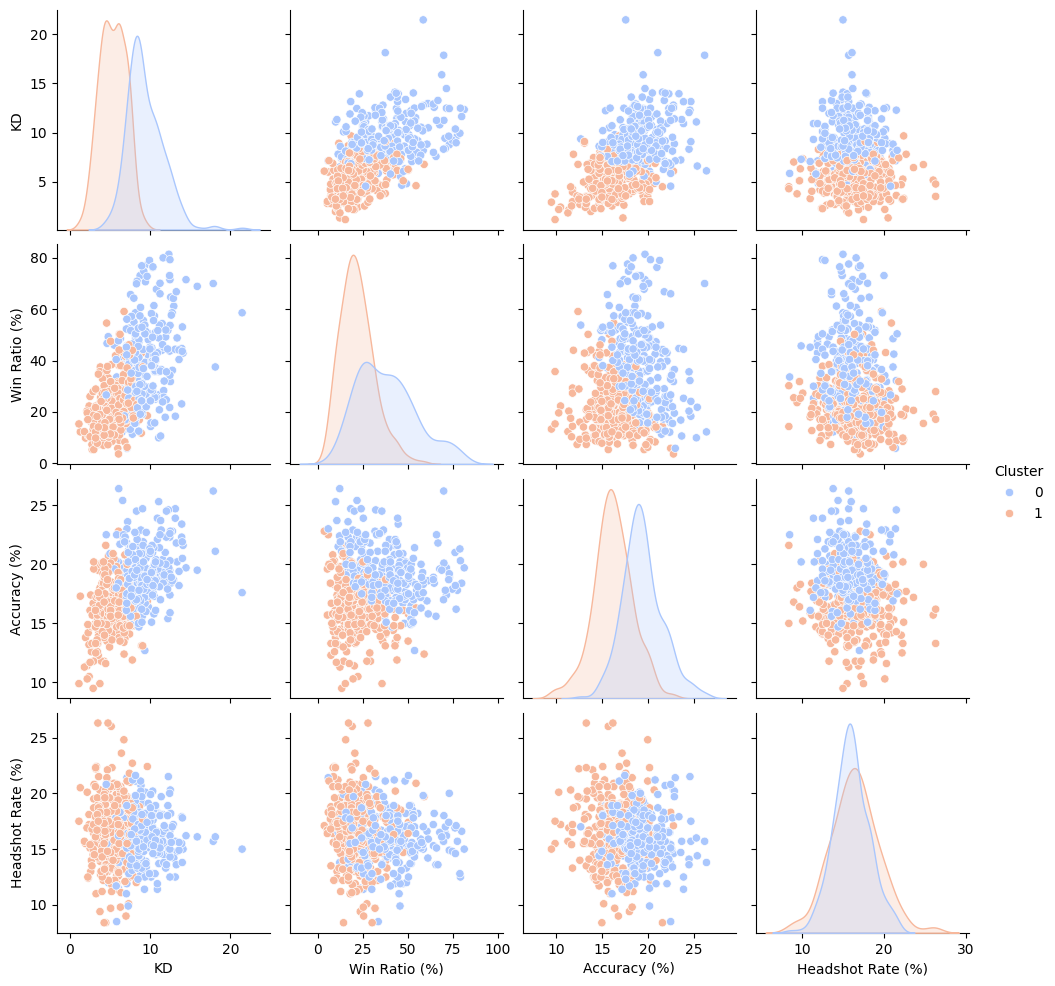

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisasi hubungan antara fitur utama
sns.pairplot(data, vars=["KD", "Win Ratio (%)", "Accuracy (%)", "Headshot Rate (%)"], hue="Cluster", palette="coolwarm")
plt.show()

In [ ]:
# Membagi data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Menampilkan jumlah data pada masing-masing set
print(f"🔹 Jumlah data Training: {len(X_train)}")
print(f"🔹 Jumlah data Testing : {len(X_test)}")

# Menampilkan distribusi label pada training dan testing
train_label_counts = Counter(y_train)
test_label_counts = Counter(y_test)

print("\n📊 Distribusi Label di Data Training:")
for label, count in train_label_counts.items():
    print(f"  Label {label}: {count} data")

print("\n📊 Distribusi Label di Data Testing:")
for label, count in test_label_counts.items():
    print(f"  Label {label}: {count} data")

🔹 Jumlah data Training: 415
🔹 Jumlah data Testing : 179

📊 Distribusi Label di Data Training:
  Label 1: 220 data
  Label 0: 195 data

📊 Distribusi Label di Data Testing:
  Label 1: 93 data
  Label 0: 86 data


In [ ]:
# Melatih model SVM dengan kernel rbf
svm_model = SVC(kernel="rbf", C=2, gamma=0.2, random_state=42, probability=True)
svm_model.fit(X_train, y_train)

bias = svm_model.intercept_[0]
print("Nilai b (bias):", bias)

# alphas = svm_model.dual_coef_
# print("Alpha * y (coef untuk support vector):", alphas)

# support_vectors = svm_model.support_vectors_
# print("Support Vectors:", support_vectors)

Nilai b (bias): -0.01786320844454083


In [ ]:
# Memprediksi hasil klasifikasi pada data uji
y_pred = svm_model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Menampilkan hasil evaluasi
print(f"\nAccuracy: {accuracy * 100:.4f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# # Tentukan path penyimpanan
# save_path = '/content/drive/MyDrive/Rekrutmen Player PUBG Mobile/model_svm_bestacc.joblib'

# # Pastikan folder tujuan ada, jika belum buat
# os.makedirs(os.path.dirname(save_path), exist_ok=True)

# # Simpan model
# joblib.dump(svm_model, save_path)

# print(f"✅ Model berhasil disimpan ke: {save_path}")


Accuracy: 98.3240%

Confusion Matrix:
[[84  2]
 [ 1 92]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        86
           1       0.98      0.99      0.98        93

    accuracy                           0.98       179
   macro avg       0.98      0.98      0.98       179
weighted avg       0.98      0.98      0.98       179



In [ ]:
# Parameter grid yang ingin diuji
param_grid = {
    'C': [1, 1.25, 1.5, 1.75, 2],
    'gamma': [0.2, 0.4, 0.6, 0.8, 1.0],
    'kernel': ['rbf']
}

# param_grid = {
#     'C': [0.1, 0.5, 1, 1.5, 2, 5, 10],
#     'gamma': [0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
#     'kernel': ['rbf']
# }

# Inisialisasi model SVM
svm = SVC()

# GridSearchCV dengan 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# Menyimpan hasil ke DataFrame untuk dilihat
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results[['param_C', 'param_gamma', 'mean_test_score']]
cv_results.rename(columns={'mean_test_score': 'cv_accuracy'}, inplace=True)

# 5. Hitung akurasi di data uji untuk setiap model hasil grid search
test_accuracies = []

for i in range(len(cv_results)):
    C_val = cv_results.iloc[i]['param_C']
    gamma_val = cv_results.iloc[i]['param_gamma']

    # Buat ulang model dengan parameter yang diuji
    model = SVC(C=C_val, gamma=gamma_val, kernel='rbf')
    model.fit(X_train, y_train)

    # Hitung akurasi di data uji
    acc = model.score(X_test, y_test)
    test_accuracies.append(acc)

# 6. Gabungkan hasil akurasi uji ke dalam dataframe
cv_results['test_accuracy'] = test_accuracies

# 7. Urutkan dari akurasi tertinggi
cv_results = cv_results.sort_values(by='cv_accuracy', ascending=False)

# 8. Tampilkan
print("📊 Hasil Grid Search (CV + Data Uji):")
print(cv_results.to_string(index=False))

📊 Hasil Grid Search (CV + Data Uji):
 param_C  param_gamma  cv_accuracy  test_accuracy
    1.75          0.8     0.980720       0.977654
    2.00          0.8     0.980662       0.972067
    1.50          0.8     0.978281       0.966480
    2.00          0.6     0.978281       0.977654
    1.75          0.6     0.978281       0.977654
    2.00          1.0     0.978223       0.972067
    1.00          0.2     0.978223       0.966480
    1.25          0.8     0.975842       0.966480
    1.25          0.2     0.975842       0.977654
    2.00          0.4     0.975842       0.983240
    1.75          1.0     0.975842       0.972067
    1.50          1.0     0.975842       0.972067
    1.50          0.6     0.975842       0.966480
    2.00          0.2     0.975784       0.983240
    1.00          1.0     0.973403       0.972067
    1.00          0.8     0.973403       0.966480
    1.25          1.0     0.973403       0.972067
    1.50          0.2     0.973403       0.977654
    1.50     

In [ ]:
# Menggunakan model terbaik untuk prediksi
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluasi model terbaik
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Menampilkan hasil evaluasi
print("\n✅ Parameter terbaik:")
print(grid_search.best_params_)
print(f"Akurasi tertinggi cross-validation: {grid_search.best_score_ * 100:.2f}%")

print(f"\n🎯 Akurasi pada data uji: {accuracy * 100:.2f}%")
print("\n🧩 Confusion Matrix:")
print(conf_matrix)
print("\n📄 Classification Report:")
print(class_report)


✅ Parameter terbaik:
{'C': 1.75, 'gamma': 0.2, 'kernel': 'rbf'}
Akurasi tertinggi cross-validation: 98.31%

🎯 Akurasi pada data uji: 97.77%

🧩 Confusion Matrix:
[[83  3]
 [ 1 92]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        86
           1       0.97      0.99      0.98        93

    accuracy                           0.98       179
   macro avg       0.98      0.98      0.98       179
weighted avg       0.98      0.98      0.98       179



In [ ]:
# Tentukan path penyimpanan
save_path = '/content/drive/MyDrive/Rekrutmen Player PUBG Mobile/best_model_svm.joblib'

# Pastikan folder tujuan ada, jika belum buat
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Simpan model
joblib.dump(svm_model, save_path)

print(f"✅ Model berhasil disimpan ke: {save_path}")

✅ Model berhasil disimpan ke: /content/drive/MyDrive/Rekrutmen Player PUBG Mobile/best_model_svm.joblib


In [ ]:
# Data baru yang akan diprediksi
data_baru = pd.DataFrame([[6.35, 16.5, 17.5, 20.6]], columns=["KD", "Win Ratio (%)", "Accuracy (%)", "Headshot Rate (%)"])

# Melakukan normalisasi menggunakan scaler yang sudah dilatih
data_baru_scaled = scaler.transform(data_baru)

# Melakukan prediksi menggunakan model SVM
hasil_prediksi = svm_model.predict(data_baru_scaled)

# Menampilkan hasil prediksi dengan label yang sudah diperbaiki
label_prediksi = "Layak" if hasil_prediksi[0] == 0 else "Tidak Layak"
print(f"Hasil Prediksi: {label_prediksi}")


Hasil Prediksi: Tidak Layak


,0,1,2,3,4,5
0,"6,35",1689,"16,5","61,7","17,5","20,6"


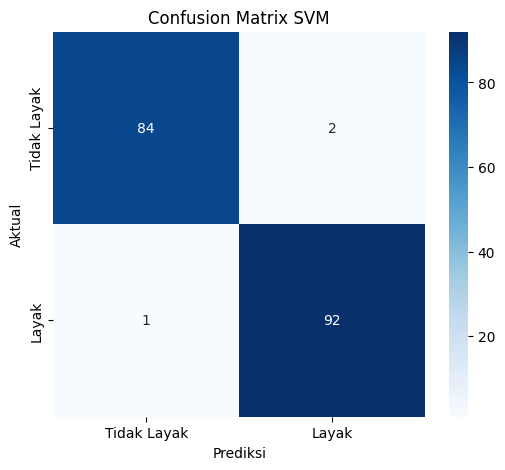

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Menghitung Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Membuat plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Tidak Layak", "Layak"], yticklabels=["Tidak Layak", "Layak"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix SVM")
plt.show()


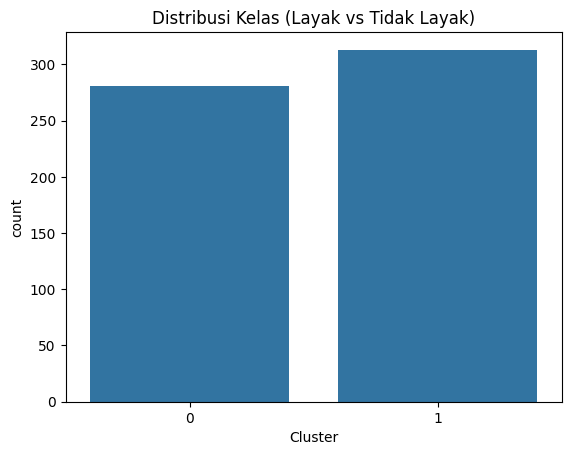

In [ ]:
import seaborn as sns

sns.countplot(x=y)
plt.title("Distribusi Kelas (Layak vs Tidak Layak)")
plt.show()
